## Tensor operations with einops

Einops is a linear algebra library that supplements Einsum. It provides functions for rearranging/reshaping, repeating and reducing tensors of arbitrary shape.

Let's install `einops` via `pip`:

In [6]:
!pip install einops

#### Import packages 

Let us first import the packages we will use:

In [123]:
from einops import rearrange, repeat, reduce
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt

#### Tensor Reshaping in 2D Convolution to a Linear Layer

Tensor reshaping is a very common operation in deep learning. This is a common operation when the output of a 2D convolutional becomes the input to a linear layer (MLP layer). In this example, we assume that the output of a 2D convolutional is an image (or feature) that we want to feed to a linear layer. In this case, we want to reshape the output of the convolutional layer to a vector that is compatible to the input of the linear layer.

Original Image shape: (224, 224, 3)


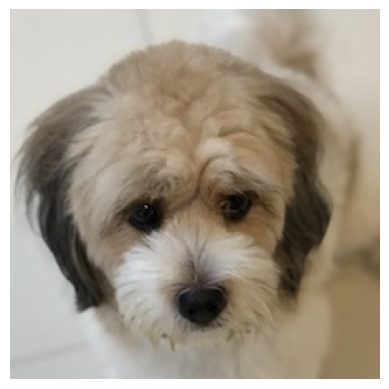

Flattened Image shape: (150528,)


In [93]:
# load the image and view it
img = image.imread("aki_dog.jpg")
print("Original Image shape:", img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

# rearrange the image to be a 1D tensor (flatten it)
img = rearrange(img, "h w c -> (h w c)")
print("Flattened Image shape:", img.shape)

In `numpy`, this can also be done by `reshape` function. 

Original Image shape: (224, 224, 3)


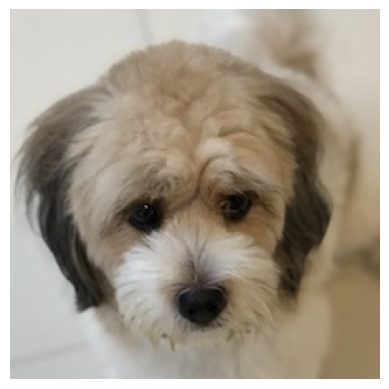

Flattened Image shape: (150528,)


In [94]:
# load the image and view it
img = image.imread("aki_dog.jpg")
print("Original Image shape:", img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

# reshape with target shape (-1,) or let np figure out the 1D size
img = np.reshape(img, (-1,))
print("Flattened Image shape:", img.shape)

#### Image to Patches in Vision Transformers

Image to patches is a common operation in vision transformer networks where an input image is split into patches. The sequence of patches becomes the input to the transformer network. In this example, we split the image into `4` patches by dividing the image height and width by `2`. The output is an array of 4 sub images with size `(h/2, w/2, 3)`. 

Original Image shape: (224, 224, 3)


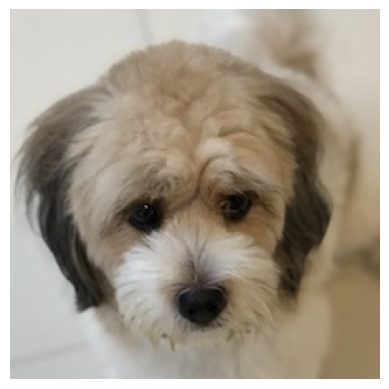

New Image shape: (4, 112, 112, 3)


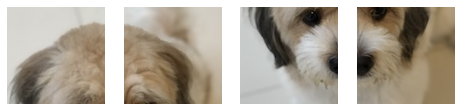

In [109]:
# load the image and view it
img = image.imread("aki_dog.jpg")
print("Original Image shape:", img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

# split the image into p1 x p2 patches. 
img = rearrange(img, "(p1 h) (p2 w) c -> (p1 p2) h w c", p1=2, p2=2)
print("New Image shape:", img.shape)

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2), dpi=72, sharex=True, sharey=True)
for i in range(len(ax)):
    ax[i].imshow(img[i])
    ax[i].axis('off')


#### Mixing 2 Images in a Single Image as done in Data Augmentation 

Mixing images is a common operation in data augmentation. Data augmentation is a type of regularization technique that improves model generalization. 

In this example, we mix two images into a single image. The output is a single image with size `(h, w, 3)`. When we mix, we take half of each and concatenate them.

Suppose we have an image of a dog and an image of a cat. We want new images where the upper half is from the dog while the lower half is from the cat. 

Let us visualize the dog and cat images:

Dog Image shape: (224, 224, 3)


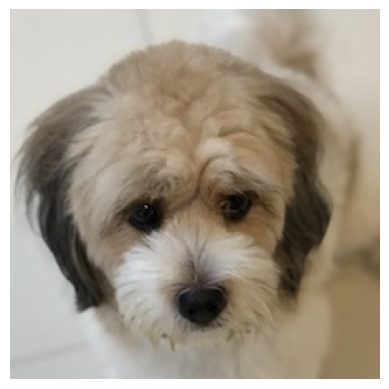

Cat Image shape: (224, 224, 3)


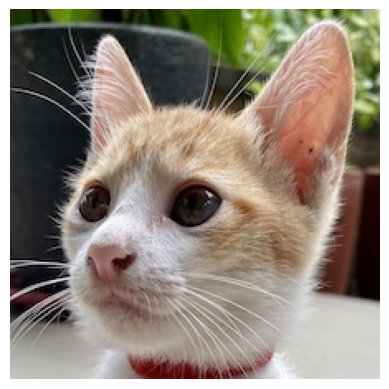

In [110]:
img1 = image.imread("aki_dog.jpg")
print("Dog Image shape:", img1.shape)
plt.imshow(img1)
plt.axis('off')
plt.show()

img2 = image.imread("wonder_cat.jpg")
print("Cat Image shape:", img2.shape)
plt.imshow(img2)
plt.axis('off')
plt.show()

The algorithm is more complicated than the above examples. Let us do it step by step.

First, let us put together the two images into a single tensor

(2, 224, 224, 3)


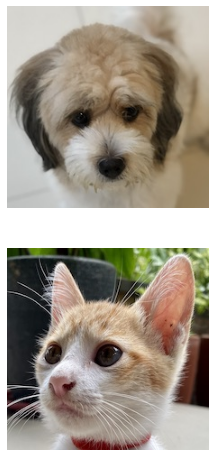

In [111]:
imgs = np.array([img1, img2])
print(imgs.shape)

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(4, 8), dpi=72, sharex=True, sharey=True)
for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')

Then, arrange the 1D array of images as a 2D array of images. Each column is made of the 2 parts of the original image.


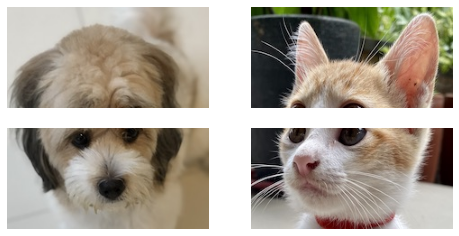

In [112]:
#### Arrange as a 2D array of upper half/lower half of images
imgs = rearrange(imgs, "b (k h) w c -> k b h w c", k =2)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), dpi=72, sharex=True, sharey=True)

for i in range(len(ax)):
    for j in range(len(ax)):
        ax[i][j].imshow(imgs[i,j])
        ax[i][j].axis('off')

Next, we reverse the order of the 2nd row.

(1, 2, 112, 224, 3)


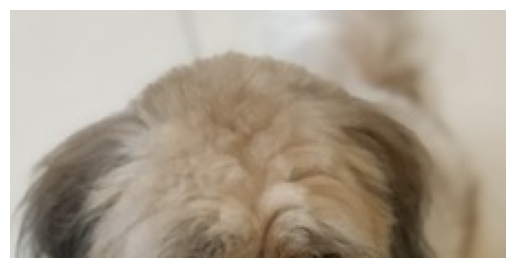

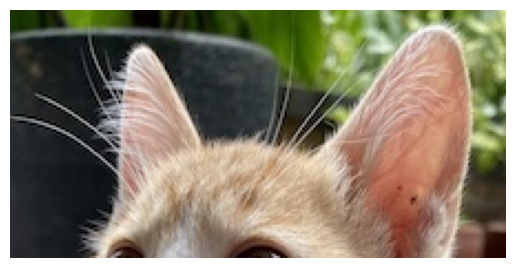

In [113]:
x = imgs[::2]
print(x.shape)
plt.imshow(x[0,0])
plt.axis('off')
plt.show()

plt.imshow(x[0,1])
plt.axis('off')
plt.show()

(1, 2, 112, 224, 3)


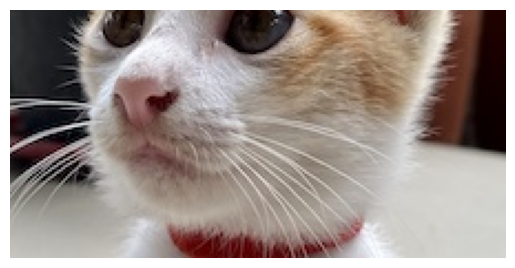

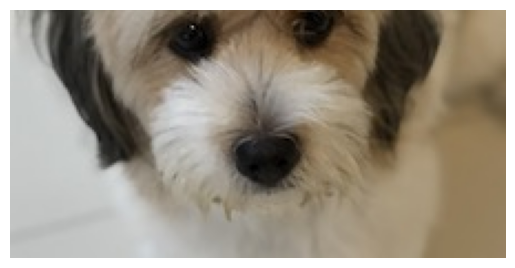

In [114]:
x = imgs[1::,::-1]
print(x.shape)
plt.imshow(x[0,0])
plt.axis('off')
plt.show()

plt.imshow(x[0,1])
plt.axis('off')
plt.show()

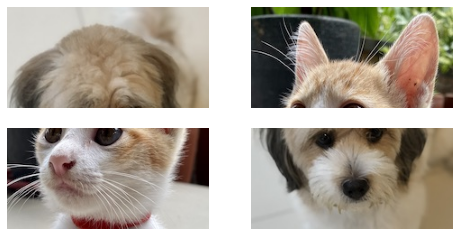

In [115]:

#### Reverse the order of the lower half of images using slicing and concatenate
imgs = np.concatenate([imgs[::2], imgs[1::,::-1]], axis=0)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), dpi=72, sharex=True, sharey=True)

for i in range(len(ax)):
    for j in range(len(ax)):
        ax[i][j].imshow(imgs[i,j])
        ax[i][j].axis('off')

The last step is we fuse the upper and lower half. After this, we now have the new synthesized images.

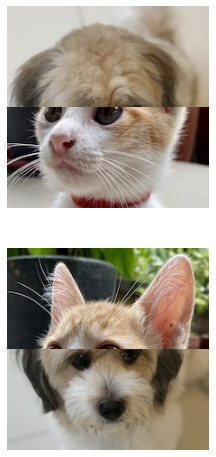

In [116]:
#### Combine the new upper and lower half of images
imgs = rearrange(imgs, "i j h w c -> j (i h) w c")

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(4, 8), dpi=72, sharex=True, sharey=True)
for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')

Putting all together, we have the following code:

(2, 224, 224, 3)


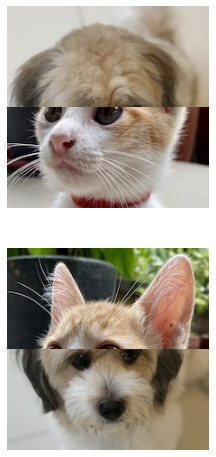

In [117]:
imgs = np.array([img1, img2])
print(imgs.shape)

#### Arrange as a 2D array of upper half/lower half of images
imgs = rearrange(imgs, "b (k h) w c -> k b h w c", k =2)

#### Reverse the order of the lower half of images
imgs = np.concatenate([imgs[::2], imgs[1::2,::-1]], axis=0)

#### Combine the new upper and lower half of images
imgs = rearrange(imgs, "i j h w c -> j (i h) w c")

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(4, 8), dpi=72, sharex=True, sharey=True)
for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')

### RGB to Grayscale
Let us load an image from the filesystem and show it.

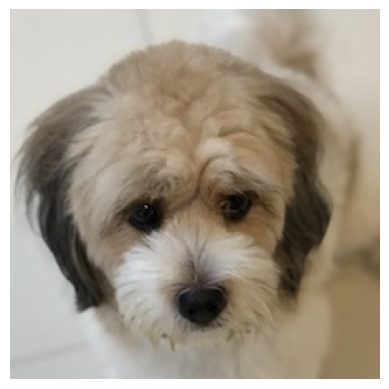

Image shape: (224, 224, 3)


In [118]:
img = image.imread("aki_dog.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

print("Image shape:", img.shape)

Convert it to grayscale.

In `numpy`, this was previously done with `img = np.mean(img, axis=-1)`.

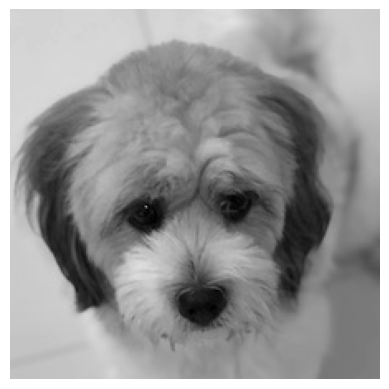

Image shape: (224, 224)


In [119]:
img = reduce(img.astype(np.float32), "h w c -> h w", 'mean')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()
print("Image shape:", img.shape)

#### Image Upsampling
Let us double the size of the image using the function `repeat`.

Original Image shape: (224, 224, 3)
New Image shape: (448, 448, 3)


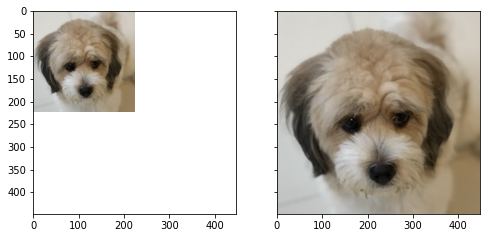

In [120]:
img1 = image.imread("aki_dog.jpg")
print("Original Image shape:", img1.shape)

img2 = repeat(img1, "h w c -> (h 2) (w 2) c")
print("New Image shape:", img2.shape)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), dpi=72, sharex=True, sharey=True)
ax[0].imshow(img1)
ax[1].imshow(img2)

#### Order of `repeat` arguments matters

Let us reverse the order from `(h 2)` to `(2 h)` and from `(w 2)` to `(2 w)`?

Original Image shape: (224, 224, 3)
New Image shape: (448, 448, 3)


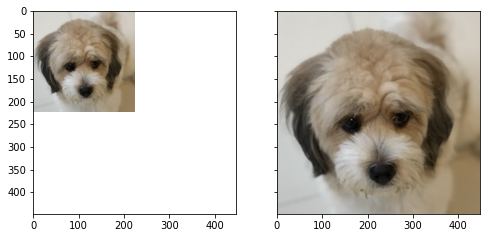

In [121]:
img1 = image.imread("aki_dog.jpg")
print("Original Image shape:", img1.shape)

img2 = repeat(img1, "h w c -> (h 2) (w 2) c")
print("New Image shape:", img2.shape)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), dpi=72, sharex=True, sharey=True)
ax[0].imshow(img1)
ax[1].imshow(img2)

#### Image Downsampling


We can use `reduce` to downsample the image. This is not straightforward to do in `numpy`.

Original Image shape: (224, 224, 3)
New Image shape: (112, 112, 3)


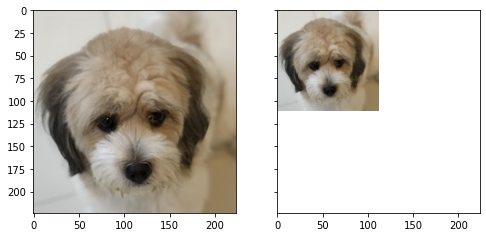

In [122]:
img1 = image.imread("aki_dog.jpg")
print("Original Image shape:", img1.shape)

img2 = reduce(img1.astype(np.float32), "(h 2) (w 2) c -> h w c", 'mean').astype(np.uint8)
print("New Image shape:", img2.shape)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), dpi=72, sharex=True, sharey=True)
ax[1].imshow(img2)
ax[0].imshow(img1)
